# SemEval 2025 Task 9
This notebook uses the trained models for inference only . If you would like to train the network yourself please head to the `ST1/final` and `ST2/final` subfolders and read the README file. Thanks in advance!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score 
 
import numpy as np

x:\Documents\AUEB\7ο Εξαμηνο\Εφαρμοσμένη Μηχανική Μάθηση\Εργασιες\3\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ST1
Final F1 Score is 0.7909, let us now go through the code.

In [2]:
os.chdir("./ST1/final/")

### Trials

After my communication with you I merged the training and validation sets to use for training and named them `combined_set.csv`. Then I used the test data for f1 evaluation.

The first thing I did was to load our datasets

In [3]:
train_df = pd.read_csv('combined_set.csv')
val_df = pd.read_csv('incidents_set.csv')

My first trials were ran local on my machine and involved trying a rough approach with Random Forest, SVM and a Neural Network. The neural network outperformed the other contenders so I scraped the idea of using anything else and focused on a NN

First a simple TF-IDF vectorization with n-grams

In [4]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10_000)
X_train = tfidf.fit_transform(train_df['text'])
X_val = tfidf.transform(val_df['text'])

A simple model prediction and evaluation to run on each model

In [5]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    return train_f1, val_f1

Our target process dispatches the models to the model evaluator. Notice `class_weight='balanced'`

In [6]:
def process_target(target_column):
    le = LabelEncoder()
    y_train = le.fit_transform(train_df[target_column])
    y_val = le.transform(val_df[target_column])
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
        'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', random_state=42),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(512,), early_stopping=True, random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        train_f1, val_f1 = evaluate_model(model, X_train, y_train, X_val, y_val)
        results[name] = (train_f1, val_f1)
    
    return results

Then we get results for each hazard and product

In [7]:
hazard_results = process_target('hazard-category')
product_results = process_target('product-category')

And finally visualize the results.

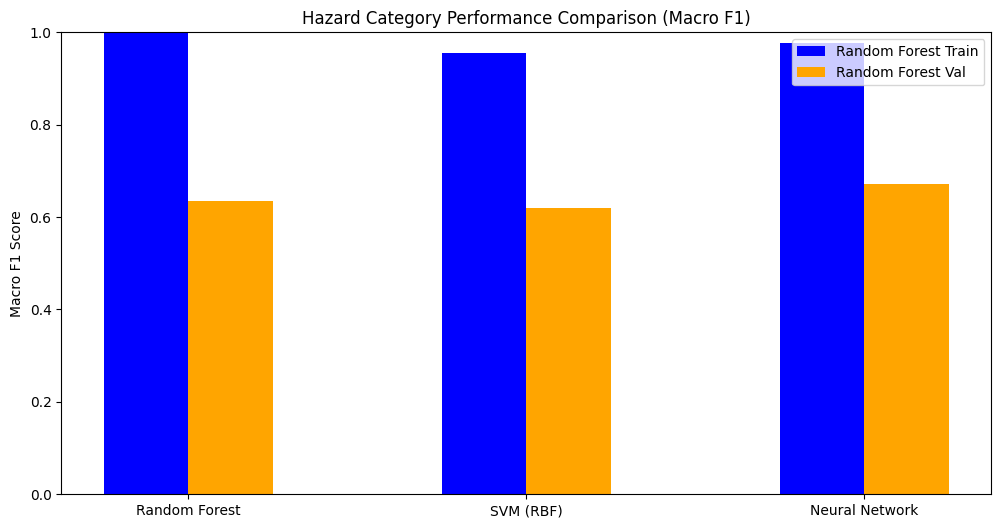

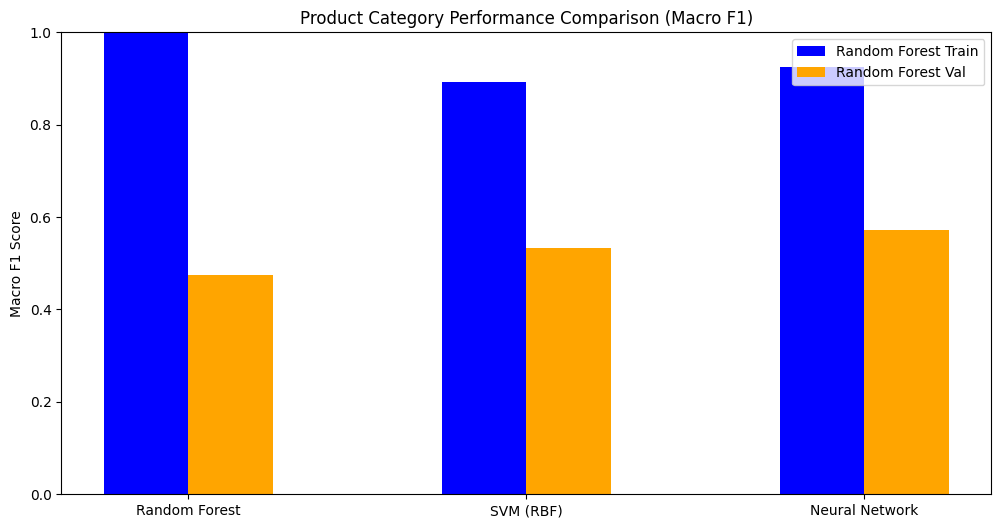

In [8]:
# Visualization
def plot_comparison(results, title):
    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(results))
    
    for i, (model, (train_f1, val_f1)) in enumerate(results.items()):
        plt.bar(i - bar_width/2, train_f1, bar_width, label=f'{model} Train' if i==0 else "", color='blue')
        plt.bar(i + bar_width/2, val_f1, bar_width, label=f'{model} Val' if i==0 else "", color='orange')
    
    plt.title(title)
    plt.ylabel('Macro F1 Score')  # Updated label
    plt.xticks(index, results.keys())
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

plot_comparison(hazard_results, 'Hazard Category Performance Comparison (Macro F1)')  # Updated title
plot_comparison(product_results, 'Product Category Performance Comparison (Macro F1)')  # Updated title

_Keep in mind the diagrams F1 scores can't be compared to the ones on SemEval as they are independently calculated for the two categories. This is a deliberate choice as I only wanted to compare between my three models to decide which one to use._

In [9]:
def print_results(results, category_name):
    print(f"Results for {category_name}:")
    for model, (train_f1, val_f1) in results.items():
        print(f"{model}: Train Accuracy = {train_f1:.4f}, Validation Accuracy = {val_f1:.4f}")
    print()

print_results(hazard_results, 'Hazard Category')
print_results(product_results, 'Product Category')


Results for Hazard Category:
Random Forest: Train Accuracy = 0.9995, Validation Accuracy = 0.6355
SVM (RBF): Train Accuracy = 0.9550, Validation Accuracy = 0.6201
Neural Network: Train Accuracy = 0.9763, Validation Accuracy = 0.6712

Results for Product Category:
Random Forest: Train Accuracy = 0.9990, Validation Accuracy = 0.4754
SVM (RBF): Train Accuracy = 0.8928, Validation Accuracy = 0.5340
Neural Network: Train Accuracy = 0.9251, Validation Accuracy = 0.5725



As the neural network seemed to perform better I decided to use it

I wanted to show my progress throughout different networks but after the first couple of runs I got fed up of waiting for training to finish. So I started to exclusively run distributed PyTorch runs, first on four and then on eight GPUs. This has the side effect of having no history for ST1.

### Model Explanation 

My model is a multi-task classification using BERT to predict the two categories. It leverages distributed training (DDP) using PyTorch and NVIDIA NCCL backend for efficiency.

- I used ChatGPT to augment the data, you can see exactly how in `ST2/ChatGPT augmentation/old_1`
- I used the transformer BERT model as the base of my double head predictor
- My Neural Network has a singular dense layer, ReLU and two dense classifier layers (Product and Hazard)
- I use the AdamW optimizer (lr=2e-5) and CrossEntropyLoss 
- I evaluate each Epoch with the average F1 score. This is different from the semeval F1 as I wanted to penalize mistakes on product classification independently from hazard

I DO NOT use early stopping. This is deliberate as I found that what worked better is just saving the best evaluated model epoch (even if both the training and testing f1 had already reached the ceiling) and running more epochs than you would expect (30 instead of 15). The testing F1 scores were regularly higher without early stopping.



### Inference 

First we set the same parameters as distributed training

In [10]:
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 512
BATCH_SIZE = 50

We recreate our Network. As we are using PyTorch we need to set up all the initial layers and their interconnections in the forward pass as if we are training. This code is copy paste from `ST1/final/training_torchrun.py`

In [11]:
class MultiTaskBERT(nn.Module):
    def __init__(self, n_hazard, n_product, model_name=MODEL_NAME):
        super(MultiTaskBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, 1200)
        self.batch_norm = nn.BatchNorm1d(1200)
        self.relu = nn.ReLU()
        self.hazard_classifier = nn.Linear(1200, n_hazard)
        self.product_classifier = nn.Linear(1200, n_product)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token output
        x = self.hidden_layer(pooled_output)
        x = self.batch_norm(x)
        x = self.relu(x)
        hazard_logits = self.hazard_classifier(x)
        product_logits = self.product_classifier(x)
        return hazard_logits, product_logits


Now we need to set up the class for the dataset we will inference

In [12]:
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Remove the extra batch dimension added by return_tensors='pt'
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

We use a Nvidia Cuda GPU if available

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Now unpickle the encoders.\
_If you have issues with unpickling restart the kernel. I mistakenly pickled inside the main function. If issues dont resolve run `ST1\final\submission_creator.py` directly_

In [14]:
with open('hazard_encoder.pkl', 'rb') as f:
    hazard_encoder = pickle.load(f)
with open('product_encoder.pkl', 'rb') as f:
    product_encoder = pickle.load(f)

n_hazard = len(hazard_encoder.classes_)
n_product = len(product_encoder.classes_)

Load our tokenizer (bert-base-uncased)

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Load our model from the saved state dictionary

In [16]:
model = MultiTaskBERT(n_hazard, n_product, model_name=MODEL_NAME)
state_dict = torch.load('best_model.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

C:\Users\Panos Dask\AppData\Local\Temp\ipykernel_61164\77745775.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('best_model.pth', map_location=de

MultiTaskBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

Load the incidents dataset

In [17]:
incidents_df = pd.read_csv('incidents_set.csv')
# Use the column "Unnamed: 0" if it exists, otherwise use the DataFrame index
if 'Unnamed: 0' in incidents_df.columns:
    index_col = incidents_df['Unnamed: 0'].values
else:
    index_col = incidents_df.index.values
texts = incidents_df['text'].values

Set up our Inference Dataset and our Loader. Then infer the results (no_grad to speed things up)

In [18]:
dataset = InferenceDataset(texts, tokenizer, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

hazard_preds = []
product_preds = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        h_logits, p_logits = model(input_ids, attention_mask)
        h_pred = torch.argmax(h_logits, dim=1)
        p_pred = torch.argmax(p_logits, dim=1)
        hazard_preds.extend(h_pred.cpu().numpy())
        product_preds.extend(p_pred.cpu().numpy())

Save our predictions to submission.csv

In [19]:
hazard_labels = hazard_encoder.inverse_transform(np.array(hazard_preds))
product_labels = product_encoder.inverse_transform(np.array(product_preds))

submission_df = pd.DataFrame({
    'Unnamed: 0': index_col,
    'hazard-category': hazard_labels,
    'product-category': product_labels
})

submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

Predictions saved to submission.csv


### F1 

The compute_score function from our assignment

In [20]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

Calculate the F1 score using ground truth 

In [21]:
df_true = pd.read_csv('incidents_set.csv', index_col=0)
df_pred = pd.read_csv('submission.csv', index_col=0)

# Rename columns to avoid conflicts during merge
df_true = df_true.rename(columns={
    'hazard-category': 'hazard_true',
    'product-category': 'product_true'
})
df_pred = df_pred.rename(columns={
    'hazard-category': 'hazard_pred',
    'product-category': 'product_pred'
})

# Merge dataframes on index to align true and predicted values
df_merged = df_true.join(df_pred, how='inner')

# Extract the aligned true and predicted values
hazards_true = df_merged['hazard_true']
products_true = df_merged['product_true']
hazards_pred = df_merged['hazard_pred']
products_pred = df_merged['product_pred']

# Calculate and print the final score
final_score = compute_score(hazards_true, products_true, hazards_pred, products_pred)
print(f"Final Evaluation Score: {final_score:.4f}")

Final Evaluation Score: 0.7909


Nice!

## ST2
Final F1 Score is 0.4731, let us now go through the code.

In [22]:
os.chdir("../../ST2/final/")

### Model Explanation

My second model is quite more complex (unfortunately). if you navigate to `ST2/final/training_torchrun.py` I have added a label `#Change from ST1` to all the parts of the code that changed.

A brief summary:
- I now load an extra augmentation file (`ChatGPT_augmentation_2.csv`) generated a bit differently. You can find out how at `ST2\ChatGPT augmentation\old_2`
- A new stratification column is created by combining the product and hazard labels
- The split ratio is changed—from a 5% test split in ST1 version to a 30% test split in ST2 
- New custom loss functions have been added. F1Loss (an approximation of the F1 metric) and a HybridF1CrossEntropyLoss that balances standard cross-entropy with the F1Loss
- Mixed precision training to speed things up (Special thanks to the documentation of pytorch and specifically the automatic mixed precision recipe)
- The shared hidden layer's size increased from 1200 to 2304
- Dropout was added
- The classification branches for both hazard and product now include additional dense layers
    - 512 Parameters and ReLU for hazard
    - 1536 Parameters and LeakyReLU for product


Some minor changes include learning rate increase, DataLoader workers increased and batch size increases

### Inference

In [23]:
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 512
BATCH_SIZE = 90  

We recreate our Network. This code is copy paste from `ST2/final/training_torchrun.py`

In [24]:
class MultiTaskBERT(nn.Module):
    def __init__(self, n_hazard, n_product, model_name=MODEL_NAME):
        super(MultiTaskBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Shared layers
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, 2304)
        self.batch_norm = nn.BatchNorm1d(2304)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        # Hazard branch
        self.hazard_dense = nn.Linear(2304, 512)
        self.hazard_activation = nn.ReLU()
        self.hazard_dropout = nn.Dropout(0.45)
        self.hazard_batch_norm = nn.LayerNorm(512)
        self.hazard_classifier = nn.Linear(512, n_hazard)
        
        # Product branch
        self.product_dense = nn.Linear(2304, 1536)
        self.product_activation = nn.LeakyReLU(0.15)
        self.product_batch_norm = nn.LayerNorm(1536)
        self.product_classifier = nn.Linear(1536, n_product)
    
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token
        
        # Shared layers
        x = self.hidden_layer(pooled_output)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Hazard branch
        hazard_x = self.hazard_dense(x)
        hazard_x = self.hazard_activation(hazard_x)
        hazard_x = self.hazard_dropout(hazard_x)
        hazard_x = self.hazard_batch_norm(hazard_x)
        hazard_output = self.hazard_classifier(hazard_x)
        
        # Product branch
        product_x = self.product_dense(x)
        product_x = self.product_batch_norm(product_x)
        product_x = self.product_activation(product_x)
        product_output = self.product_classifier(product_x)
        
        return hazard_output, product_output

We can keep the Inference Dataset from ST1

Now unpickle the encoders.\
_If you have issues with unpickling restart the kernel. I mistakenly pickled inside the main function. If issues dont resolve run `ST2\final\submission_creator.py` directly_

In [25]:
with open('hazard_encoder.pkl', 'rb') as f:
    hazard_encoder = pickle.load(f)
with open('product_encoder.pkl', 'rb') as f:
    product_encoder = pickle.load(f)

n_hazard = len(hazard_encoder.classes_)
n_product = len(product_encoder.classes_)

Load our tokenizer (bert-base-uncased)

In [26]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Load our model from the saved state dictionary

In [27]:
model = MultiTaskBERT(n_hazard, n_product, model_name=MODEL_NAME)
state_dict = torch.load('best_model.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

C:\Users\Panos Dask\AppData\Local\Temp\ipykernel_61164\77745775.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('best_model.pth', map_location=de

MultiTaskBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [28]:
incidents_df = pd.read_csv('incidents_set.csv')
# Use the column "Unnamed: 0" if it exists, otherwise use the DataFrame index
if 'Unnamed: 0' in incidents_df.columns:
    index_col = incidents_df['Unnamed: 0'].values
else:
    index_col = incidents_df.index.values
texts = incidents_df['text'].values

Set up our Inference Dataset and our Loader. Then infer the results (no_grad to speed things up)

In [29]:
dataset = InferenceDataset(texts, tokenizer, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

hazard_preds = []
product_preds = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        h_logits, p_logits = model(input_ids, attention_mask)
        h_pred = torch.argmax(h_logits, dim=1)
        p_pred = torch.argmax(p_logits, dim=1)
        hazard_preds.extend(h_pred.cpu().numpy())
        product_preds.extend(p_pred.cpu().numpy())

Save our predictions to submission.csv

In [30]:
hazard_labels = hazard_encoder.inverse_transform(np.array(hazard_preds))
product_labels = product_encoder.inverse_transform(np.array(product_preds))

submission_df = pd.DataFrame({
    'Unnamed: 0': index_col,
    'hazard': hazard_labels,
    'product': product_labels
})

submission_df.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv


### F1 

The compute_score function is the same as `ST1`

Calculate the F1 score using ground truth 

In [31]:
# Load the ground truth and submission files
df_true = pd.read_csv('incidents_set.csv', index_col=0)
df_pred = pd.read_csv('submission.csv', index_col=0)

# Rename columns to avoid conflicts during merge
df_true = df_true.rename(columns={
    'hazard': 'hazard_true',
    'product': 'product_true'
})
df_pred = df_pred.rename(columns={
    'hazard': 'hazard_pred',
    'product': 'product_pred'
})

# Merge dataframes on index to align true and predicted values
df_merged = df_true.join(df_pred, how='inner')

# Extract the aligned true and predicted values
hazards_true = df_merged['hazard_true']
products_true = df_merged['product_true']
hazards_pred = df_merged['hazard_pred']
products_pred = df_merged['product_pred']

# Calculate and print the final score
final_score = compute_score(hazards_true, products_true, hazards_pred, products_pred)
print(f"Final Evaluation Score: {final_score:.4f}")

Final Evaluation Score: 0.4731


Very Good!

If you would like to see a historic ledger for ST2 training please open the `Training stuff.xlsx` file